# Basic one site + bath


## Outline of the problem


We explore

- a fermonic system (single site) in contact with a fermionic bath
- the bath is formed by $n$ sites, discretising a custom spectral function $J(\omega)$
- the bath sites are all independent 
- the simplest approach is to simply **evolve** the correlation matrix

 $$C = \langle c_i^\dagger c_j\rangle$$

 where $c, c^\dagger $ are the annihilation/creation operators.

 Since the global Hamiltonian is in the form 

 $$ \hat{H} = \sum_{ij}^{n+1} H_{ij}  c_i^{\dagger}c_j $$

it is **quadratic** and by Wick's theorem *[find a good understandable reference]* this means that **higher-order correlations** can be expressed **solely** as **combinations** of the pair-wise correlation matrix $C$.

Note that the matrix $H_{ij}$ ($(n+1)\times (n+1)$) should be easy to express explicitely in terms of the couplings [do this below].

Given $\hat{H}$, we can then calculate the unitary $U$ as

 $$ U(t)= e^{-i \hat{H} t}$$


The evolution of an initial matrix $C_0= C(t=0)$ is then

$$C(t) = U C_0 U^{\dagger}$$


Which we we should be able to do explicitly in Julia or Python.


For my personal convenience, I will start in Python and then translate it into Julia as needed.

We are now left with the problem of 

- specifying the Hamiltonian coefficients $H_{ij}$ (which are time independent)
- specifying the initial correlation matrix $C_0$

## Setting up the Hamiltonian

The Hamiltonian written above is determined by $H_{ij}$. This contains 

- the energy of the system $\epsilon$
- the system-bath couplings
- the individual bath site energies

So, the total hamiltonian should look like

$$\hat{H} = \epsilon \hat{s}^{\dagger}\hat{s} +\sum_k\sqrt{J_k}(\hat{b}_k^{\dagger} \hat{s}+ \hat{s}^{\dagger} \hat{b}_k)+\sum_k \omega_k \hat{b}_k^{\dagger} \hat{b}_k $$

where i am using $s$ for the site and $b$ for the bath. $\epsilon$, $J_k$ and $\omega$ are all real (Q: is this too restrictive?).

So let $i=0$ be the index for the system and $i=1,\dots, n$ be the index of for the bath:

- H is then a symmetric matrix with zeros everywhere excpeting the diagional and the first row and column

To specify the couplings I need to choose a spectral function. I start with the semicircle of radius $D$ (can i call this bandwidth?)

$$J(\omega) = \sqrt{1- (\omega/D)^2}$$

I may want also a scale to one this [ASK DAVE HOW THEY CHOOSE THIS].

[[ 0.        +0.j  0.        +0.j  0.00138726+0.j ...  0.00164835+0.j
   0.00138726+0.j  0.        +0.j]
 [ 0.        +0.j -1.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.00138726+0.j  0.        +0.j -0.99331104+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 ...
 [ 0.00164835+0.j  0.        +0.j  0.        +0.j ...  0.98662207+0.j
   0.        +0.j  0.        +0.j]
 [ 0.00138726+0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.99331104+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  1.        +0.j]]


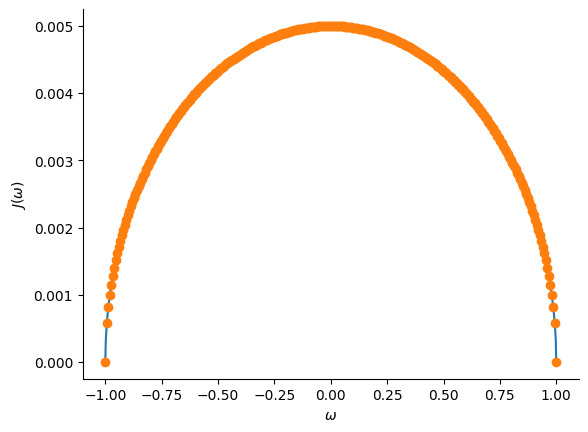

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def J(omega, prefactor=0.005,D=1):
    "Spectral function of choice"
    return prefactor*np.sqrt(1.-(omega/D)**2)

n = 300 # an arbitrary choice for now, not too large
N  = n+1

H = np.zeros((N,N),dtype=np.complex128)
epsilon = 0.0 # our scale of energies

D = 1.0 # choice of the bandwidth
omegas = np.linspace(-D, D,n) #discretisation of the bath
Js = J(omegas,D=D)

# first column
# scaled for correct thermodynamic limit, since the rates depend on j_i^2
H[1:,0] = np.sqrt(Js)/np.sqrt(n)
# first row
H[0,1:] = np.sqrt(Js)/np.sqrt(n)
# diagonal
np.fill_diagonal(H, [epsilon]+list(omegas))
print(H)
# plot the spectral function and its discretisation
_x = np.linspace(omegas.min(),omegas.max(),1000)
plt.plot(_x, J(_x))
plt.plot(omegas, Js, 'o')
plt.gca().set(xlabel="$\omega$", ylabel="$J(\omega)$");

## Setting up the initial state


As we have a fermionic system, we assume that the initial state is governed by the **Fermi distribution**.


The assumption is that there are **no initial correlations**, so $C_0$ should be **diagonal** with only the **occupation numbers** on the diagonal.

These occupation numbers are determined by the Fermi-Diac statistics:

$$C_{ii}  = \dfrac{1}{1+e^{\beta E_i-\beta\mu}}$$

where $E_i$ are the energis of the sites (including the bath)

In [17]:
C0 = np.zeros_like(H)
# choosing the temperature
beta = 1.0
mu =0
fermi = lambda x:1/(1+np.exp(beta*x-beta*mu))

density_0 = 0
np.fill_diagonal(C0,[0]+[fermi(o) for o in omegas])

C0


array([[0.        +0.j, 0.        +0.j, 0.        +0.j, ...,
        0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.73105858+0.j, 0.        +0.j, ...,
        0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.72974142+0.j, ...,
        0.        +0.j, 0.        +0.j, 0.        +0.j],
       ...,
       [0.        +0.j, 0.        +0.j, 0.        +0.j, ...,
        0.2715798 +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, ...,
        0.        +0.j, 0.27025858+0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, ...,
        0.        +0.j, 0.        +0.j, 0.26894142+0.j]])

The matrix is initially diagonal in the **site basis**, not in the Hamiltonian basis.

In [18]:
from scipy.linalg import eigh
e_vals, U = eigh(H)  # H = U @ diag(e_vals) @ U.conj().T
# Step 1: Diagonalize H
e_vals, U = eigh(H)  # H = U @ diag(e_vals) @ U.conj().T

# Step 2: Transform C0 into the energy eigenbasis
C_energy_basis = U.conj().T @ C0 @ U

# Step 3: Check diagonality
off_diagonal_norm = np.linalg.norm(C_energy_basis - np.diag(np.diagonal(C_energy_basis)))
print("Off-diagonal norm of C in energy basis:", off_diagonal_norm)




Off-diagonal norm of C in energy basis: 0.4710277075112684


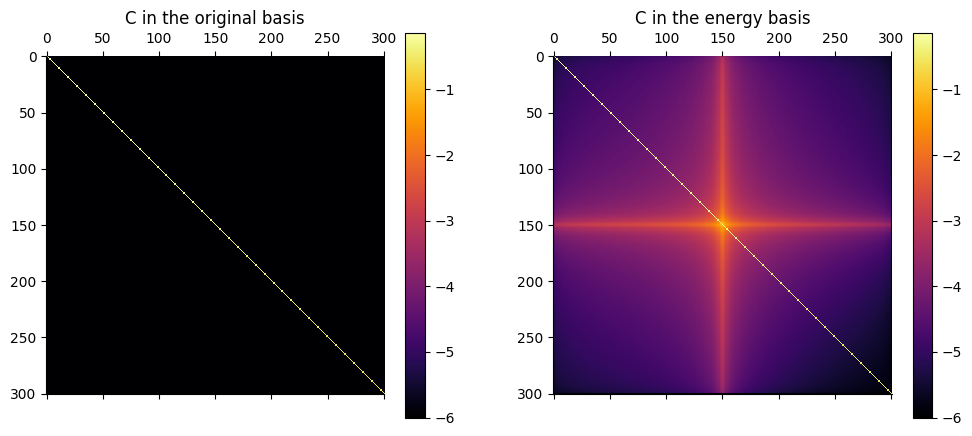

In [19]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(1,2,figsize=(12,5))
im0 = ax[0].matshow(np.log10(np.abs(C0) + 1e-6), cmap="inferno")
im1 = ax[1].matshow(np.log10(np.abs(C_energy_basis) + 1e-6), cmap="inferno")
ax[0].set_title("C in the original basis")
ax[1].set_title("C in the energy basis")
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])


## Construct the unitary


The last missing bit is just the construction of the unitary.


The unitary can be constructed using the formula
$$U(t)= e^{-i \hat{H} t}$$

This can be done using the `scipy.linalg.expm` function which computes the matrix exponential.

In [20]:
import scipy
def unitary(t):
    return np.matrix(scipy.linalg.expm(-1j*H*t))

## Calculating observables

The time evolution is then trivial (but maybe inefficient).


In [21]:
def evolve(C,t):
    U = unitary(t)
    return U@C@U.H




We can calculate multiple correlation matrices at various times and try and plot how they vary over time.

I need to set up some tests to see if this makes sense.

In [34]:
dt = 0.1
tmax = 1000.
times = np.arange(0,tmax, dt)

In [23]:
# direct calculation
# Cs = {t:evolve(C0,t) for t in times}

In [24]:
# supposedly faster iterative calculation
Udt = unitary(dt)
UdtT = Udt.H
Css ={0:C0}
key = 0
for t in times[1:]:
    Css[t] = Udt@Css[key]@UdtT
    key = t

In [25]:
# count = 0
# for key,val in Css.items():
#     if count%10==0:
#         plt.figure()
#         plt.matshow(np.log(np.abs(val.real)))
#         plt.title(f"t={key}")
#         plt.tight_layout()
#         plt.savefig(f"C-time{key}.png")
#         plt.close()
#     count+=1

## Time evolution of the density on the system

In [26]:
density = np.array([ val [0,0] for key, val in Css.items()])

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Occupation on the system')]

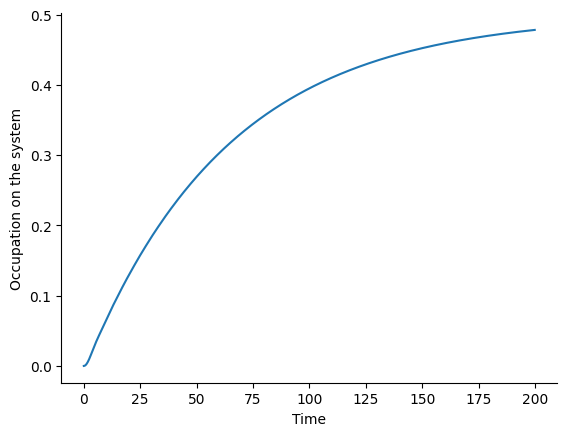

In [27]:
plt.plot(times, density.real)
plt.gca().set(
    xlabel = "Time",
    ylabel = "Occupation on the system"
)

The total system (site + finite bath) is closed and finite, so the dynamics seems (quasi)-periodic.

The system site cannot fully relax to a steady value like in an infinite bath (no true dissipation).

The oscillations shoudl go down as we increase the bath size.

## Overall occupation in the bath

/Users/ft14968/.pyenv/versions/3.11.1/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/ft14968/.pyenv/versions/3.11.1/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[Text(0.5, 0, '$\\omega$'), Text(0, 0.5, 'Occupation')]

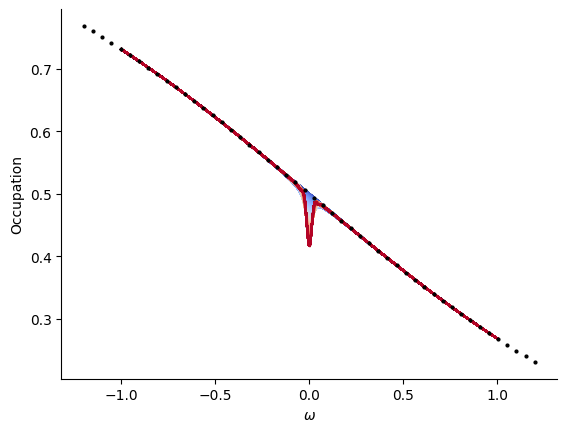

In [28]:
for key,val in Css.items():
    plt.plot(omegas,np.diagonal(val[1:,1:]), color= plt.cm.coolwarm(key/tmax))

u = np.linspace(-1.2, 1.2, 50)
plt.plot(u,fermi(u), '.',color='k',ms=4)
# plt.plot(omegas,fermi(omegas), '-',color='white', lw=2)
plt.gca().set(
    xlabel = "$\omega$",
    ylabel = "Occupation"
)

It seems reasonable, but the kink is a bit surprising. Probably a finite size effect?

## Tentative implementation with `pytorch`

Using a dedicated library for large matrix multiplications on GPU should help...

Things that make the code slow

- Number of bath sites `n`
- Total duration

Some performance numbers, for dt=0.1 and total time 200 on my Macbook Pro:

- For 300 sites, the numpy/scipy code takes around 10 seconds, `pytorch` takes 5 seconds.
- For 500 sites, the numpy/scipy code takes around 50 seconds, `pytorch` takes 18 seconds.
- For 1000 sites, the numpy/scipy code takes around 4.5 min,  `pytorch` 2min and 9 seconds. 

So there is 2x speedup. It should be much better on large NVIDIA GPUs (e.g. on HPC)

In [35]:
import torch

# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found. Using GPU acceleration.")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU.")


MPS device found. Using GPU acceleration.


In [36]:
Udt = unitary(dt)
UdtT = torch.from_numpy(Udt.H)
Udt = torch.from_numpy(unitary(dt))
Css ={0:torch.from_numpy(C0)}
key = 0
for t in times[1:]:
    Css[t] = Udt@Css[key]@UdtT
    key = t

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Occupation on the site')]

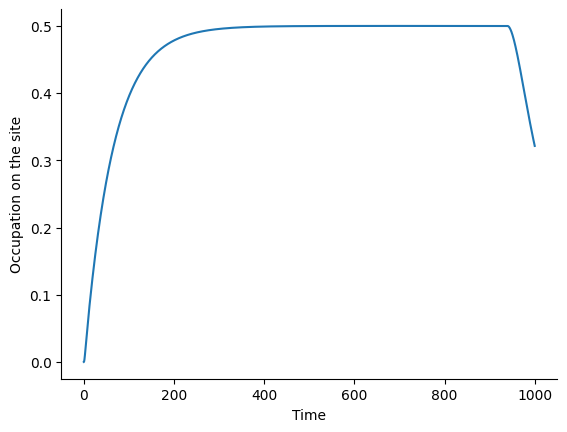

In [37]:
density = np.array([ val [0,0] for key, val in Css.items()])
plt.plot(times, density.real)
plt.gca().set(
    xlabel = "Time",
    ylabel = "Occupation on the site"
)

In [33]:
plt.matshow(np.log(np.abs(Css[950]+1e-6)))
plt.colorbar()

KeyError: 950

## Preliminary things to understand

### On convergence

- How does the convergence depend on the quality of the time discretisation
- How does it truly depend on the number of bath sites (on CPU and GPUs)?
- How does it depend on alternative choices of the initial state
- How does it compare with alternative methods (e.g. the matrix product state (MPS) approach)? 

### On the physics

- What happens to the covariance matrix as we time evolve? Does it show any emergent structure? 
- How do these structures relate to the initial choice of the spectral function?
- Let's perturb the spectral function: can we see long-lived memory effects building up?

